In [1]:
%cd ..

/workspace/work/MVA/LLM/chess_bot


/opt/conda/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from src.valid_chess import GPT_valid_chess
from src.utils import CfgNode as CN
import json
import torch
from safetensors.torch import load_model, save_model
import re
import chess
from stockfish import Stockfish
from IPython.display import display, clear_output
import numpy as np
conf = 'config.json'

In [2]:
C = CN()

with open(conf) as f:
    config = json.load(f)

C.n_layer = config["n_layer"]
C.n_embd = config["n_embd"]
C.n_head = config["n_head"]
C.embd_pdrop = config["embd_pdrop"]
C.resid_pdrop = config["resid_pdrop"]
C.attn_pdrop = config["attn_pdrop"]
C.block_size = 768

chars = ['0', '5', '2', 'Q', 'e', 'a', 'R', 'd', '9', '8', '1', 'N', 'x', 'f', '6', '+', 'c', '=', 'h', 'O', 'B', '.', '7', '/', '4', '3', '*', 'b', '-', ' ', 'K', 'g', '#', ';', '[PAD]']

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

C.vocab_size = len(stoi)
C.vocabulary = chars

model = GPT_valid_chess(C).eval()
load_model(model, "models/stockfish-16/model.safetensors")

number of parameters: 50.85M


(set(), [])

In [ ]:
def get_next_llm(history, round_number, temp):
    encoded_text = torch.tensor(encode(history), dtype=torch.int64).unsqueeze(0)
    output = model.generate_valid_chess_move(encoded_text, board, 10, do_sample=True, temperature=temp).squeeze()
    decoded_text = decode(output.tolist())
    match = re.search(fr"{round_number}\.([a-zA-Z0-9-\+\#\=]*)", decoded_text)
    new_move = match.group(1).strip()
    return new_move

def get_next_llm_kv(history, round_number, kv_cache, temp):
    encoded_text = torch.tensor(encode(history), dtype=torch.int64).unsqueeze(0)
    output, kv_cache = model.generate(encoded_text, 10, do_sample=True, temperature=temp, kv_cache=kv_cache, return_kv_cache=True)
    output = output.squeeze()
    decoded_text = decode(output.tolist())
    match = re.search(fr"{round_number}\.([a-zA-Z0-9-\+\#\=]*)", decoded_text)
    new_move = match.group(1).strip()
    return new_move, kv_cache

def get_next_stockfish(next_move):
    try:
        board_move = board.parse_san(next_move)
        check = True 
    except Exception as err:
        print(f"Illegal move {err=}, {type(err)=}")
        check = False
    if check:
        board.push(board_move)
        if board.is_checkmate():
            print("Checkmate!")
            return (next_move, None, 2)
        if board.is_stalemate():
            print("Stalemate!")
            return (next_move, None, 1)
        stockfish.make_moves_from_current_position([ board_move ])
        best = stockfish.get_best_move()
        stockfish.make_moves_from_current_position([ best ])
        move = chess.Move.from_uci(best)
        st_san = board.san(move)
        board.push(move)
        if board.is_checkmate():
            print("Checkmate!")
            return (next_move, None, 3)
        if board.is_stalemate():
            print("Stalemate!")
            return (next_move, None, 1)
        clear_output()
        return (next_move, st_san, 0)
    else:
        print(f"{next_move} is not correct")
        return (next_move, None, -1)

In [ ]:
import time
from tqdm import tqdm
temperatures = [0.01, 0.5, 1.0]
for temp in temperatures:
    elos = [1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3200]
    N = 40
    n_w = [0]*len(elos)
    n_l = [0]*len(elos)
    n_d = [0]*len(elos)
    n_p = [0]*len(elos)
    number_of_rounds = [[]]*len(elos)
    for s_i, elo in tqdm(enumerate(elos), total=len(elos)):
        for _ in tqdm(range(N)):
            board = chess.Board()
            stockfish = Stockfish(
                path="/home/infres/nvernier-22/bin/stockfish",#this line should be mofified!
                depth=3,
                parameters={
                    "Threads": 2,
                    "Minimum Thinking Time": 30,
                    "UCI_Elo": elo,
                    },
            )
            history = ";1-0#1."
            round_number = 1
            play = True
            with_kv_cache = False
            kv_cache = None

            times = []
            t = time.time()

            illegal_count = 0
            while play:
                move_stockfish = None
                while not move_stockfish:
                    # print("round number:",round_number)
                    next_move = get_next_llm(history, round_number, temp)
                    # print("LLM move:",next_move)
                    _, move_stockfish, game_val = get_next_stockfish(next_move)
                    # print("Stockfish move:",move_stockfish)
                    if game_val == 3:
                        play = False
                        print("Stockfish Won")
                        n_l[s_i] += 1
                        break
                    if game_val == 2:
                        play = False
                        print("ChessLLM Won")
                        n_w[s_i] += 1
                        break
                    if game_val == 1:
                        play = False
                        print("No Winner")
                        n_d[s_i] += 1
                        break
                    if game_val == -1:
                        print("Illegal move")
                        illegal_count += 1

                    if round_number > 80 or illegal_count > 10:
                        play = False
                        print("Too many rounds")
                        n_p[s_i] += 1
                        break

                round_number += 1
                if game_val == 0:
                    history = f"{history}{next_move} {move_stockfish} {round_number}."
                if game_val == 2:
                    history = f"{history}{next_move}"
                if game_val == 3:
                    history = f"{history}{next_move} {move_stockfish}"
                # display(board)
                times.append(time.time() - t)
                t = time.time()
            number_of_rounds[s_i].append(round_number)
    print(n_w)
    print(n_l)
    print(n_d)
    print(n_p)
    print(number_of_rounds)
    np.save(f"results/n_w_temp_{temp}.npy", n_w)
    np.save(f"results/n_l_temp_{temp}.npy", n_l)
    np.save(f"results/n_d_temp_{temp}.npy", n_d)
    np.save(f"results/n_p_temp_{temp}.npy", n_p)
    np.save(f"results/number_of_rounds_temp_{temp}.npy", number_of_rounds)

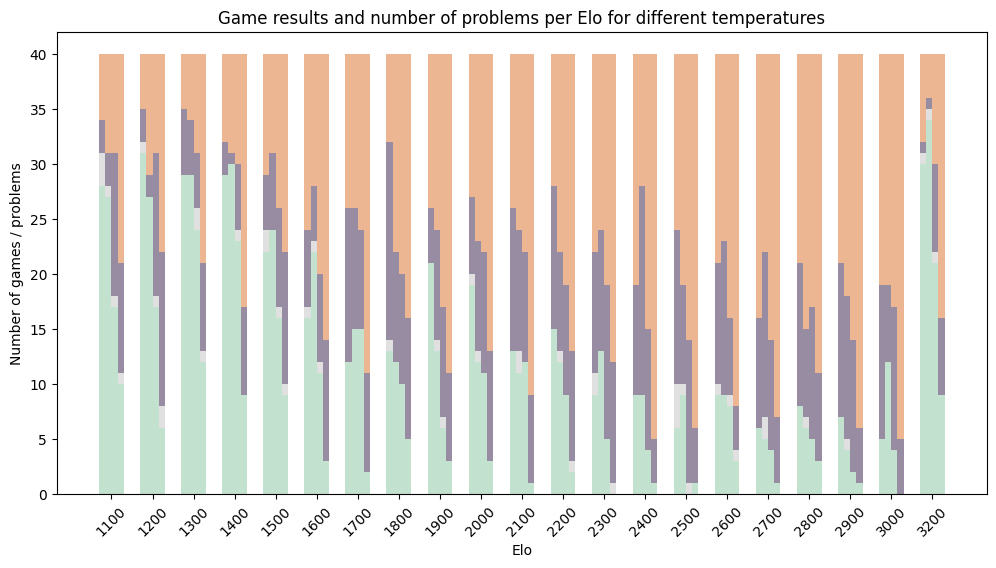

In [3]:
import numpy as np
import matplotlib.pyplot as plt

temps = [0.01, 0.1, 0.5, 1.0]
elos = [1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 
        2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3200]

bar_width = 0.15
offset = [-1.5*bar_width, -0.5*bar_width, 0.5*bar_width, 1.5*bar_width] 
colors = ['#A8D5BA', '#D3D3D3', '#E59866', '#FFB347']
labels = ['T=0.01', 'T=0.1', 'T=0.5', 'T=1.0']

fig, ax = plt.subplots(figsize=(12, 6))

for i, temp in enumerate(temps):
    # Load data
    wins_white = np.load(f"results/n_w_temp_{temp}.npy")
    wins_black = np.load(f"results/n_l_temp_{temp}.npy")
    draws = np.load(f"results/n_d_temp_{temp}.npy")
    n_problems = np.load(f"results/n_p_temp_{temp}.npy")
    
    bar_positions = np.arange(len(elos)) + offset[i] 
    
    ax.bar(bar_positions, wins_white, bar_width, label=f'White Wins ({labels[i]})', color=colors[0], alpha=0.7)
    ax.bar(bar_positions, draws, bar_width, bottom=wins_white, color=colors[1], alpha=0.7)
    ax.bar(bar_positions, n_problems, bar_width, bottom=np.array(wins_white) + np.array(draws), color='#6C5B7B', alpha=0.7)
    ax.bar(bar_positions, wins_black, bar_width, bottom=np.array(wins_white) + np.array(draws) + np.array(n_problems), color=colors[2], alpha=0.7)

ax.set_xticks(np.arange(len(elos)))
ax.set_xticklabels(elos, rotation=45)
ax.set_xlabel("Elo")
ax.set_ylabel("Number of games / problems")
ax.set_title("Game results and number of problems per Elo for different temperatures")

plt.show()